# SETUP

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
ds = tf.keras.utils.image_dataset_from_directory("zelle", label_mode=None, image_size=(448, 448), batch_size=16)

In [ ]:
imgs = ds.as_numpy_iterator().__next__()

In [ ]:
plt.imshow((imgs[0]).astype(np.uint8))

In [ ]:
X_train = imgs/255

# BUILD ENCODER

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU


from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_encoder(latent_dimension):
    
    input_image=Input(shape=(448,448,3))

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU())(x)
    x= BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
           
    x = Flatten()(x)
    encoder_output=Dense(latent_dimension, activation='relu')(x)
           
    encoder = Model(inputs=input_image, outputs=encoder_output)

    return encoder

In [ ]:
encoder = build_encoder(latent_dimension=800)

In [20]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 448, 448, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856 

# BUILD DECODER

In [21]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
def build_decoder(latent_dimension):
    
    latent_space_input=Input(shape=latent_dimension)

    x=Dense(7*7*64, activation='tanh')(latent_space_input)
    x=Reshape((7, 7, 64))(x)
    x=Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x=Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x=Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x=Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
    x=Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu')(x)

    decoder_output=Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
    decoder = Model(inputs=latent_space_input, outputs=decoder_output)
    
    return decoder

In [22]:
decoder = build_decoder(800)
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 800)]             0         
                                                                 
 dense_2 (Dense)             (None, 3136)              2511936   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 128)      73856     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 56, 56, 32)       1846

# BUILD AUTOENCODER

In [23]:
def build_autoencoder(encoder, decoder):
    inp = Input((448, 448, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [24]:
autoencoder = build_autoencoder(encoder, decoder)

In [25]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 model (Functional)          (None, 800)               160953440 
                                                                 
 model_4 (Functional)        (None, 448, 448, 3)       2684051   
                                                                 
Total params: 163,637,491
Trainable params: 163,636,979
Non-trainable params: 512
_________________________________________________________________


# COMPILE AUTOENCODER

In [18]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

# RUN AUTOENCODER

In [26]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

compile_autoencoder(autoencoder)

autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, callbacks=[es], verbose=1)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2282
Epoch 2/100
1/1 [==============================] - 1s 642ms/step - loss: 0.2278
Epoch 3/100
1/1 [==============================] - 1s 631ms/step - loss: 0.2273
Epoch 4/100
1/1 [==============================] - 1s 636ms/step - loss: 0.2268
Epoch 5/100
1/1 [==============================] - 1s 645ms/step - loss: 0.2261
Epoch 6/100
1/1 [==============================] - 1s 640ms/step - loss: 0.2252
Epoch 7/100
1/1 [==============================] - 1s 731ms/step - loss: 0.2241
Epoch 8/100
1/1 [==============================] - 1s 654ms/step - loss: 0.2225
Epoch 9/100
1/1 [==============================] - 1s 640ms/step - loss: 0.2202
Epoch 10/100
1/1 [==============================] - 1s 642ms/step - loss: 0.2170
Epoch 11/100
1/1 [==============================] - 1s 625ms/step - loss: 0.2124
Epoch 12/100
1/1 [==============================] - 1s 625ms/step - loss: 0.2060
Epoch 13/100
1/1 [======================

In [27]:
prediction=autoencoder.predict(X_train, verbose=0, batch_size = 32)

In [28]:
prediction.shape

(16, 448, 448, 3)

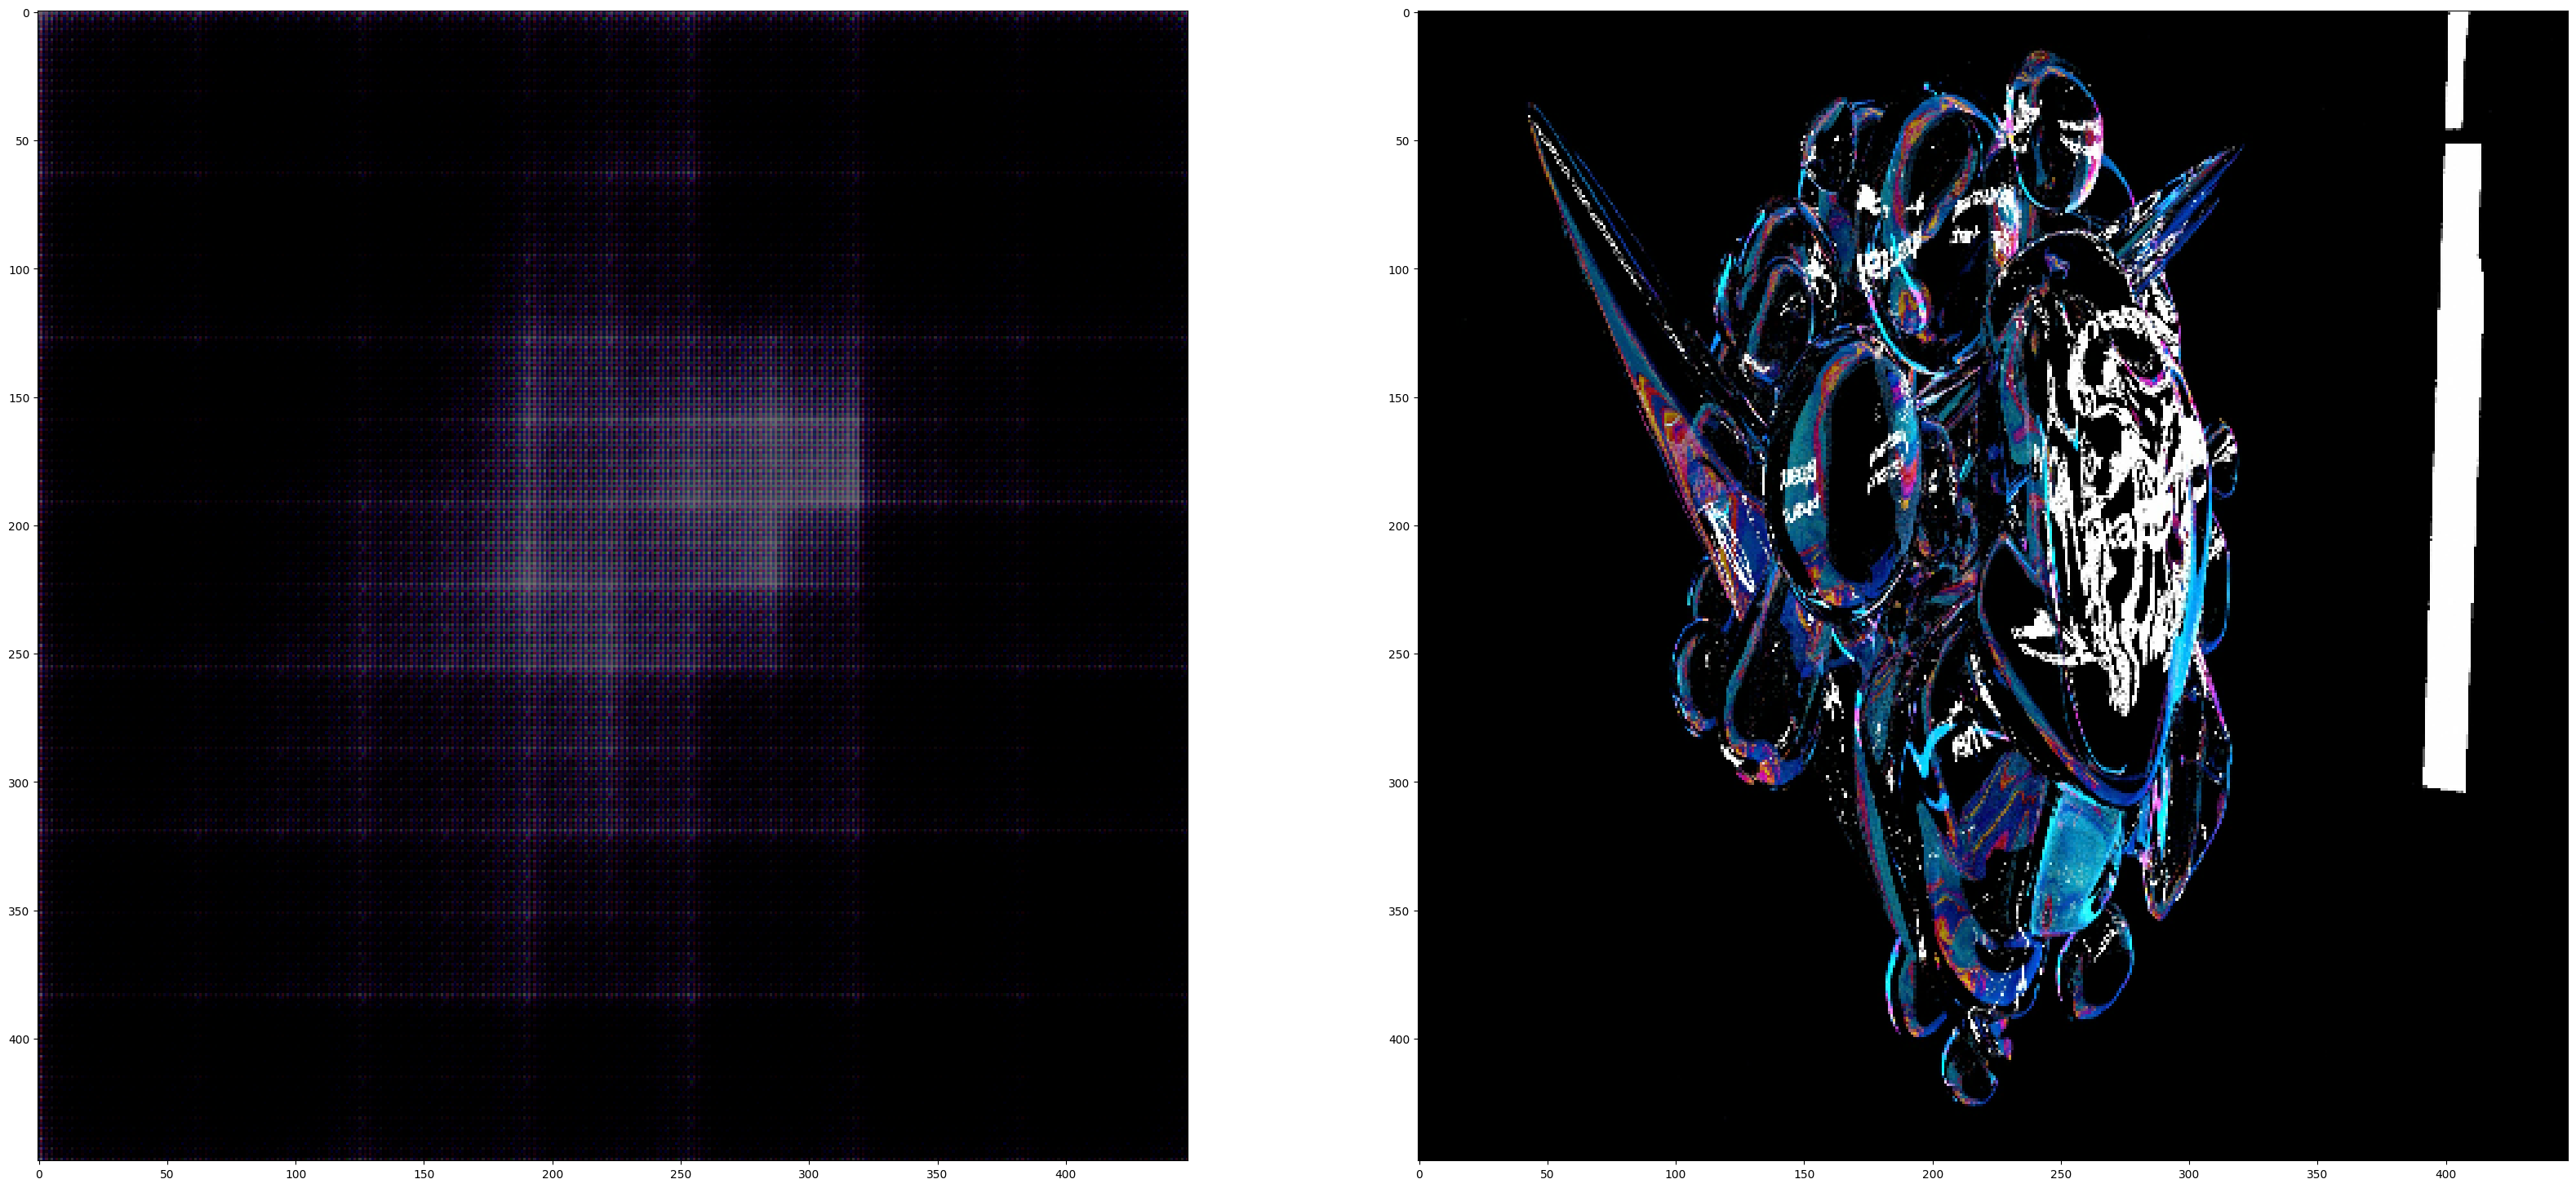

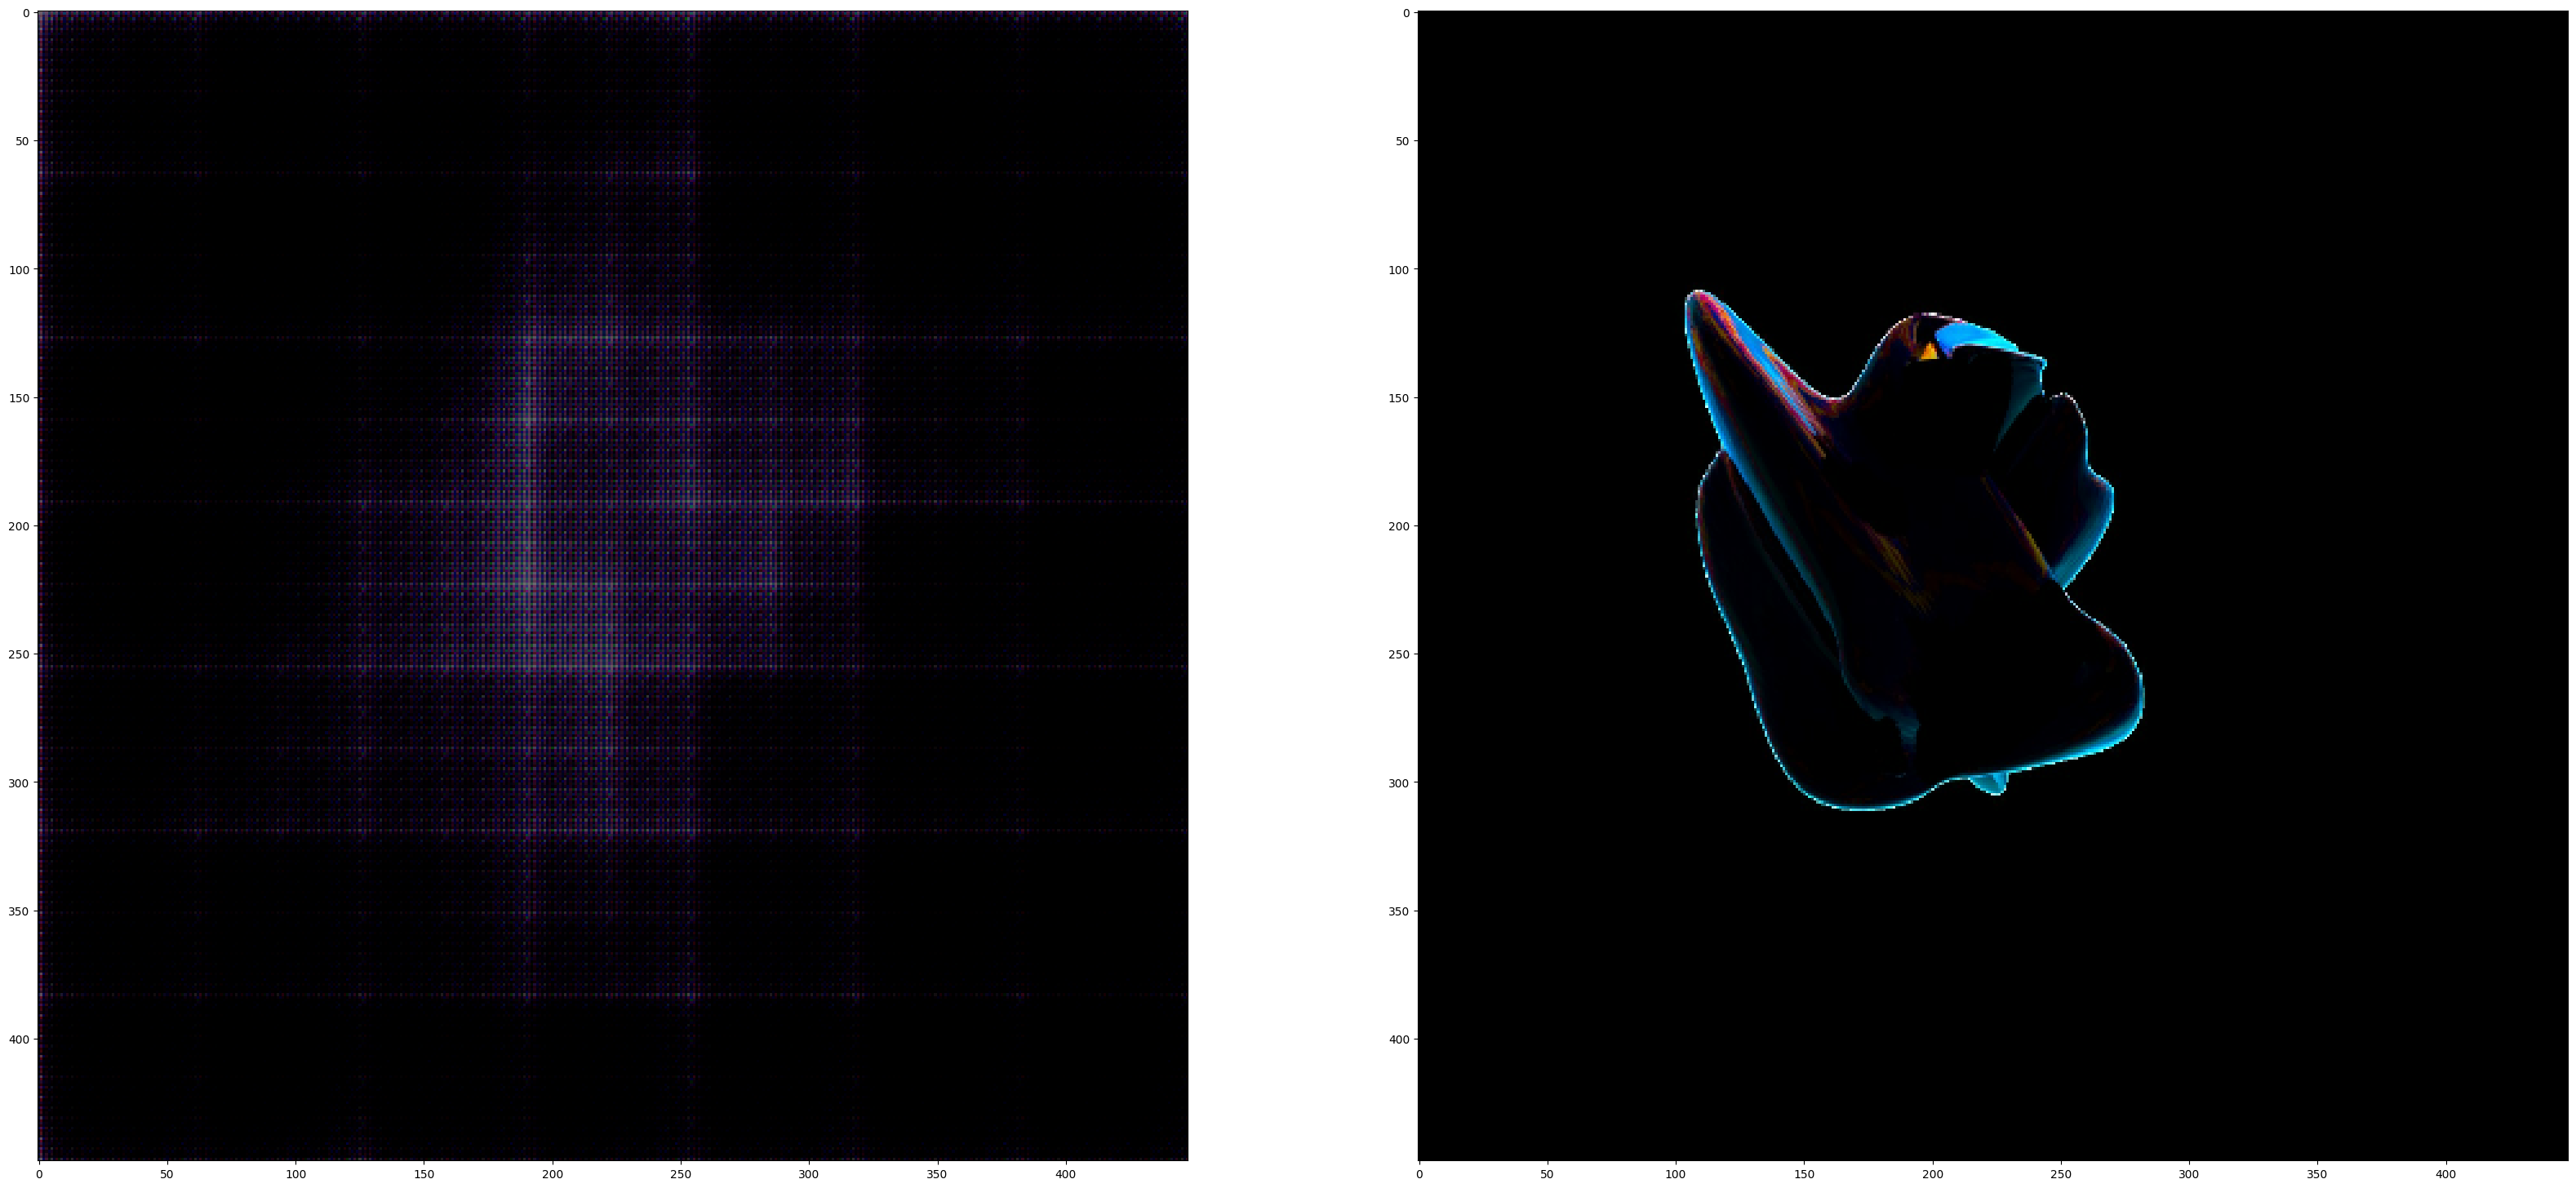

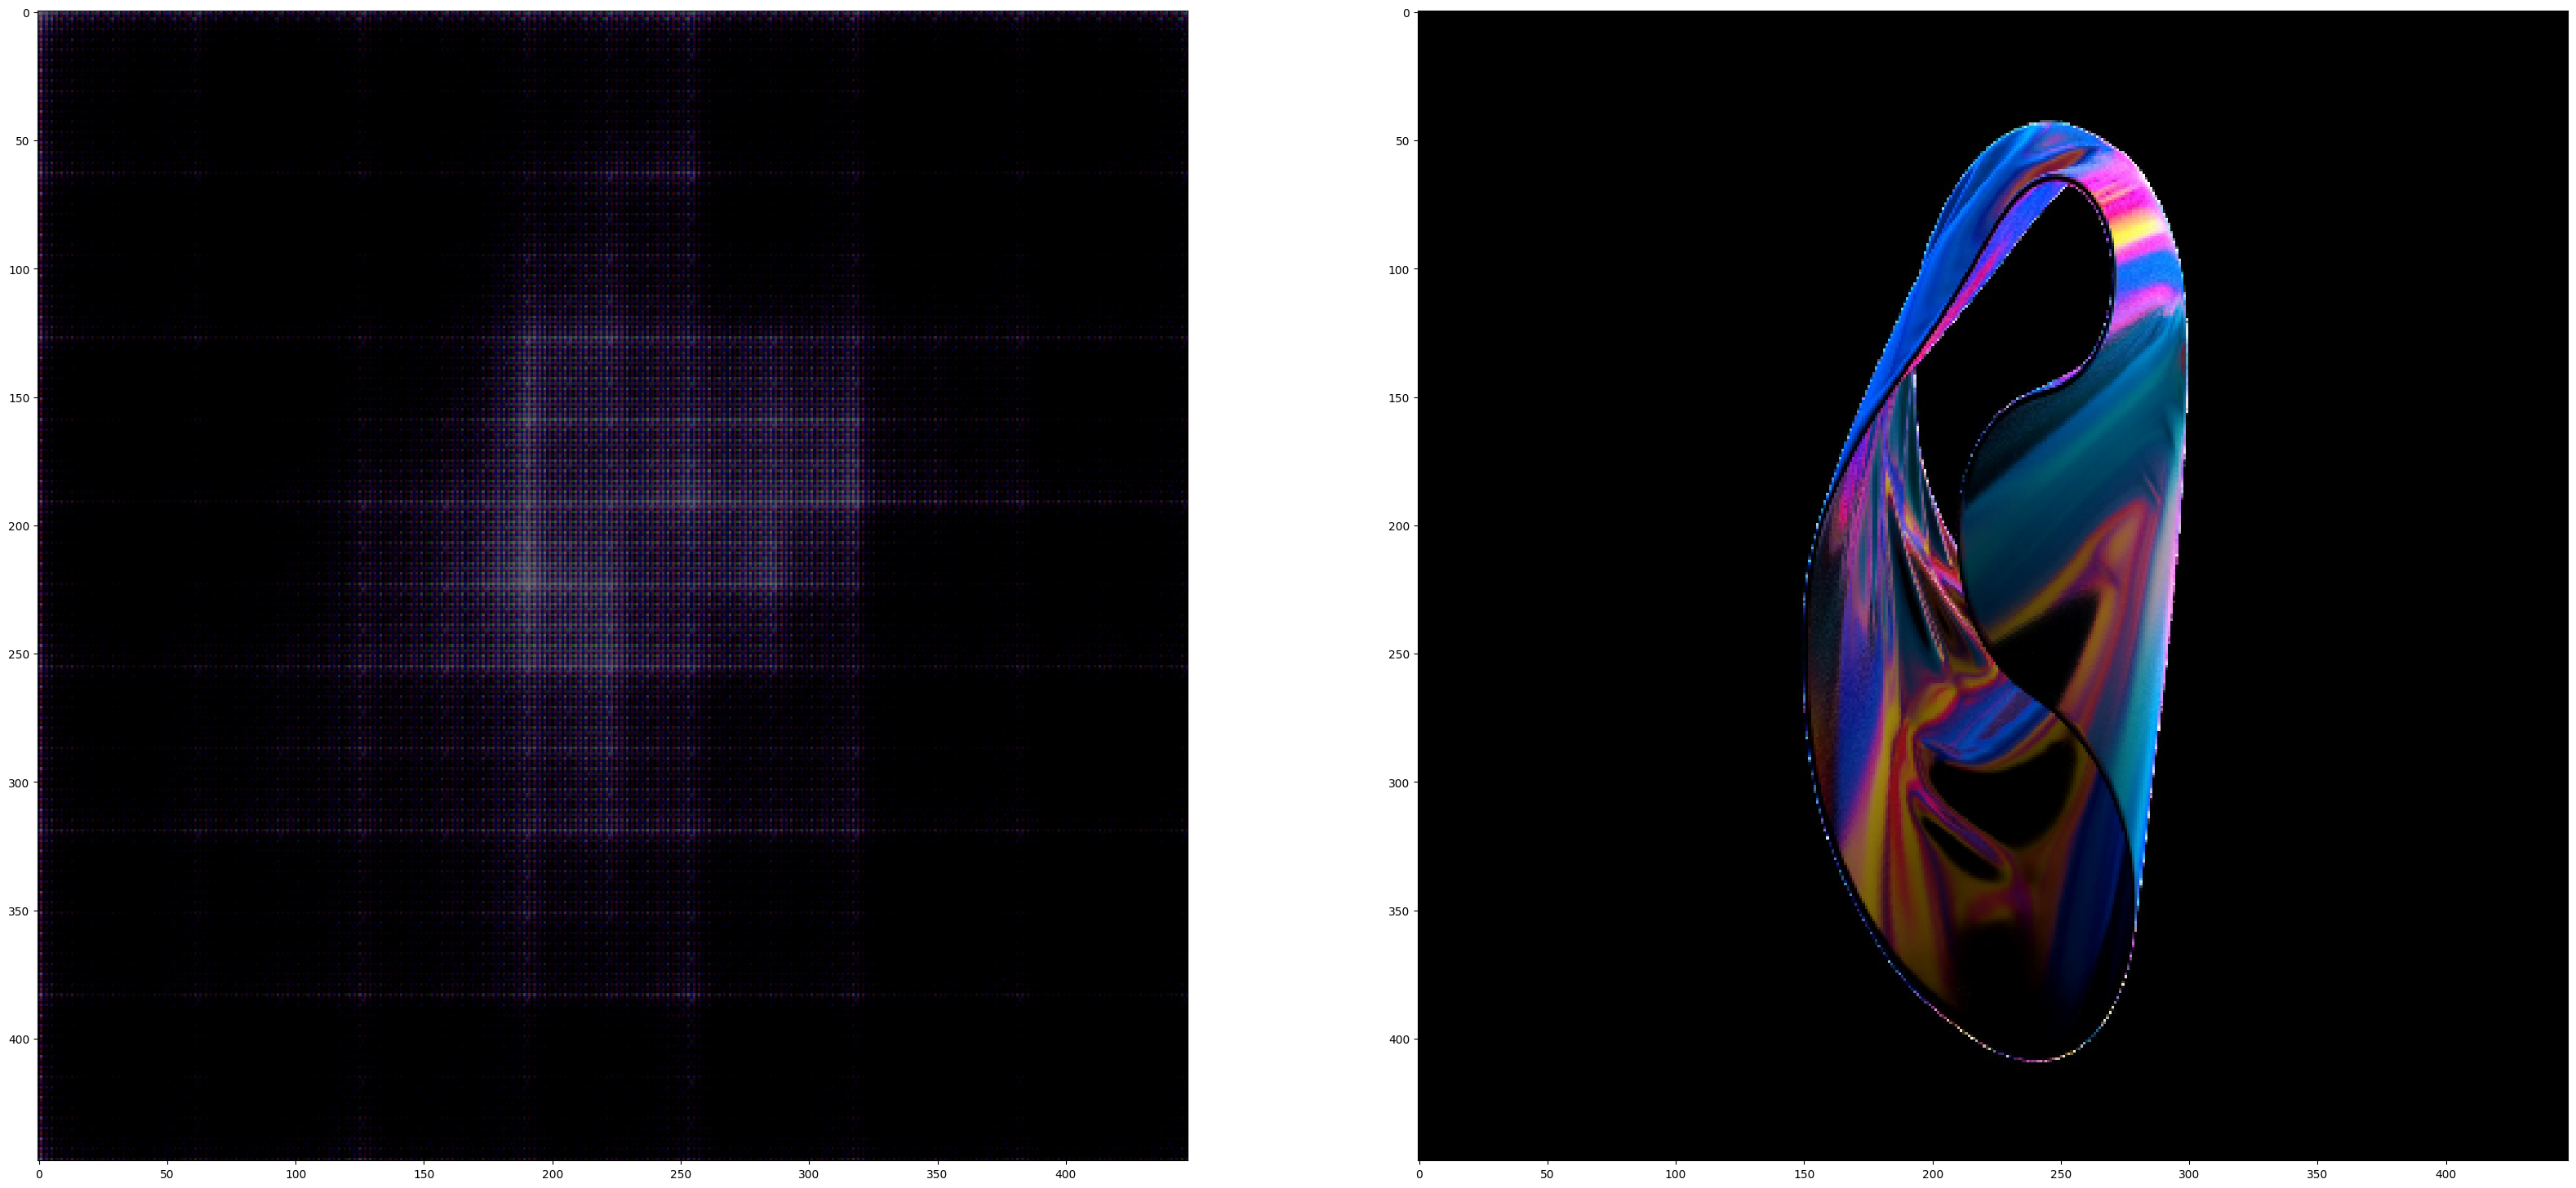

In [29]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

# LATENT SPACE

In [30]:
latent_space = encoder.predict(X_train)

1/1 [==============================] - 0s 112ms/step


In [31]:
from tensorflow.keras.models import load_model
from tensorflow.random import normal
from tensorflow.math import exp
from tensorflow import shape

In [56]:
latent_dimension=800

In [62]:
autoencoder_model = autoencoder

latent_space_input=Input(shape=latent_dimension)

x=Dense(7*7*64, activation='tanh')(latent_space_input)
x=Reshape((7, 7, 64))(x)
x=Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
x=Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
x=Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
x=Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation='relu')(x)
x=Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu')(x)


##decoder_output=Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)

decoder_output=Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
##decoder = Model(inputs=latent_space_input, outputs=decoder_output)

decoder = Model(inputs=latent_space_input, outputs=decoder_output)

# Generate output from a given z vector
latent_dimension=800
z_mu = Dense(latent_dimension)(latent_space_input)
z_log_sigma = Dense(latent_dimension)(latent_space_input)
epsilon = normal(shape(z_mu))
z = z_mu + exp(z_log_sigma / 2) * epsilon


In [64]:
z_decoded = decoder(z)
z_decoded

<KerasTensor: shape=(None, 448, 448, 3) dtype=float32 (created by layer 'model_12')>

In [36]:
from tensorflow.keras.backend import backend as K
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Lambda

In [ ]:
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([latent_space_input, z_decoded])


NameError: name 'Layer' is not defined

In [ ]:

# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

NameError: name 'input_img' is not defined

In [ ]:
something=z_decoded*prediction
something

<KerasTensor: shape=(16, 448, 448, 3) dtype=float32 (created by layer 'tf.math.multiply_2')>

In [ ]:
autoencoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 model (Functional)          (None, 800)               160953440 
                                                                 
 model_1 (Functional)        (None, 448, 448, 3)       2684051   
                                                                 
Total params: 163,637,491
Trainable params: 163,636,979
Non-trainable params: 512
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 800)]             0         
                                                                 
 dense_7 (Dense)             (None, 3136)              2511936   
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 28, 28, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 56, 56, 32)       1846

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:
something_array=something.eval()

In [ ]:
my_array = something.numpy()

# Plot the image using matplotlib
plt.imshow(my_array)
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(something, show_shapes=True)

In [ ]:
decoder(np.ones(800).reshape(-1,800))

In [ ]:
from tensorflow.math import square
from tensorflow.math import reduce_mean
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
def vae_loss(inputs, outputs, z_mean, z_log_var):
    # Compute reconstruction loss
    reconstruction_loss = MeanSquaredError(inputs, outputs)
    reconstruction_loss *= 448 * 448 * 3  # Scale up to match size of inputs
    
    # Compute KL divergence loss
    kl_loss = 1 + z_log_var - square(z_mean) - exp(z_log_var)
    kl_loss = reduce_mean(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    # Combine losses
    total_loss = reduce_mean(reconstruction_loss + kl_loss)
    return total_loss

In [ ]:
autoencoder_model.compile(optimizer='adam', run_eagerly = True, loss=lambda prediction,  z_decoded: vae_loss(X_train,z_decoded, z_mu, z_log_sigma))

In [ ]:
z_model=autoencoder_model.fit(X_train,  y=None, epochs = 200, batch_size = 32, callbacks=[es], validation_data=(X_train, None))

# ADDING NOISE

In [ ]:
noise_factor = 0.1

X_train_noisy = X_train + noise_factor * np.random.normal(0., 1., size=X_train.shape)

In [ ]:
noisy=autoencoder.fit(X_train_noisy, X_train, epochs = 10000, batch_size = 32, callbacks=[es])

In [ ]:
noisyprediction=autoencoder.predict(X_train, verbose=0, batch_size = 32)

In [ ]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((noisyprediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(108, 144, 3))
    plt.show()

In [ ]:
noise_factor2 = 0.5

X_train_noisy2 = X_train + noise_factor2 * np.random.normal(0., 1., size=X_train.shape)

In [ ]:
noisy2=autoencoder.fit(X_train_noisy2, X_train, epochs = 20000, batch_size = 32, callbacks=[es])

In [ ]:
noisyprediction2=autoencoder.predict(X_train_noisy2, verbose=0, batch_size = 32)

In [ ]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((noisyprediction2[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(108, 144, 3))
    plt.show()

In [ ]:
noise_factor3 = 1

X_train_noisy3 = X_train + noise_factor3 * np.random.normal(0., 1., size=X_train.shape)

In [ ]:
noisy3=autoencoder.fit(X_train_noisy3, X_train, epochs = 20000, batch_size = 32, callbacks=[es])

In [ ]:
noisyprediction3=autoencoder.predict(X_train_noisy3, verbose=0, batch_size = 32)

In [ ]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((noisyprediction3[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(108, 144, 3))
    plt.show()

In [ ]:
noise_factor4 = 2

X_train_noisy4 = X_train + noise_factor4 * np.random.normal(0., 1., size=X_train.shape)

In [ ]:
noisy4=autoencoder.fit(X_train_noisy4, X_train, epochs = 20000, batch_size = 32, callbacks=[es])

In [ ]:
noisyprediction4=autoencoder.predict(X_train_noisy4, verbose=0, batch_size = 32)

In [ ]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((noisyprediction4[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(108, 144, 3))
    plt.show()